# Обзор пакетов SciPy, Pyomo и CVXPY для решения задач условной оптимизации

Привет, Habr! На связи отдел аналитики данных X5 Tech.


В этой статье мы продолжим говорить про прикладное применение теории оптимизации.
В [предыдущей статье](https://habr.com/ru/company/X5Tech/blog/685590/) мы описали основные типы оптимизационных задач,
перечислили несколько примеров задач из области ритейла, а также сравнили
производительности двух оптимизаторов для решения модельной задачи ценообразования на языке Python.

В данной статье мы сделаем краткий обзор существующих open-source решений в Python, с которыми мы сталкивались на практике.
Затронем их различия и особенности, приведём примеры задач, которые можно решать с их помощью.


## Обзор пакетов Python


Для упрощения восприятия материала, отобразим взаимосвязи тип задачи - солвер в виде схемы:

<img src="images/solvers.jpg" alt="drawing" width="600"/>

Далее в указанном порядке будем рассматривать эти пакеты и говорить о важных, на наш взгляд,
деталях их реализации, и иллюстрировать на примерах задач условной оптимизации.


### SciPy

[__SciPy__](https://scipy.org/) - одна из первых библиотек в Python, знакомство с которой начинается у специалистов
в области Data Science - она содержит большой набор функций для научных вычислений,
в том числе имеет инструменты для решения оптимизационных задач, находящиеся в модуле __scipy.optimize__.
В этом модуле имеются методы для решения задач как нелинейного программирования (__NLP__),
 так и линейного программирования (__LP__), в том числе задач смешанного целочисленного линейного программирования(__MILP__).


Среди солверов, которые поддерживают решение задач условной оптимизации (NLP) можно выделить __cobyla__, __slsqp__, __trust-constr__.
Обзор методов, литературы и примеры применения солверов можно найти [тут](https://habr.com/ru/company/ods/blog/448054/).
Здесь же вкратце отметим, что __сobyla__ - это метод, позволяющий производить оптимизацию функции, градиент которой неизвестен,
т.е. по сути заниматься оптимизацией "черного ящика".
Также стоит обратить внимание на то, что __cobyla__ не поддерживает ограничения типа равенства: $a(x) = b$. Связанно это с особенностями
реализации солвера, который внутри себя вызывает scipy. Эту проблему можно обойти, заменив ограничение на два ограничения вида
неравенства: $a(x) \leq b$ и $a(x) \geq b$, которое равносильно равенству. Также __cobyla__ не поддерживает границы для переменных $x$,
задаваемых через параметр bounds в функции __minimize__ (из модуля scipy.optimize) - их необходимо задавать через линейные ограничения, например с помощью LinearConstraint.
Что касается __slsqp__, __trust-constr__, то это методы уже второго порядка, соответственно, для них требуется существование и непрерывность 1-ой и 2-ой производных.

Рассмотрим небольшой пример применения метода minimize, иллюстрирующий полезность масштабирования, основанный на постановке задачи ценообразования
из [статьи 1](https://habr.com/ru/company/X5Tech/blog/685590/) - максимизация выручки с сохранением текущего уровня маржи с ограниченным
диапазоном изменения цены в пределах ±10% от текущей.
Обозначения:

$n$ - количество товаров,

$P_{0, i}$ - текущая цена товара $i$,

$Q_{0, i}$ - текущие продажи,

$x_{i} = P_{i} / P_{0, i}$ - отношение новой цены $P_{i}$ к текущей $P_{0, i}$,

$E_{i}$ - параметр для пересчета спроса на товар по формуле $Q_{i}(x) = Q_{0, i} \\cdot \\exp(E_{i} \\cdot (x_{i} - 1))$,

$R_{i}(x_{i}) = \\sum_{i=1}^{n} P_{0, i} \\cdot x_{i} \\cdot Q_{i}(x_i) $ - выручка, которая для каждого товара определяется как произведение его цены на продажи,

$M_{i}(x_{i}) = \sum_{i=1}^{n} (P_{0, i} \cdot x_{i} - C_{i})\cdot Q_{0, i} \cdot Q_{i}(x_i) $ - маржа,

$M_{0} = \sum_{i=1}^{n} M_{i}(x_{i}=1)$ - текущая маржа, т.е. её значение при текущей цене,

\begin{cases}
\tag{1}
\sum_{i=1}^{n} R_{i}(x_{i}) \to \max,
\\
\sum_{i=1}^{n} M_{i}(x_{i}) \geqslant M_{0},
\\
x_i \in [0.9, 1.1], \ i=1..n\\
\end{cases}

In [1]:
# мини пример из постановки первой статьи
import scipy.optimize as scopt
import numpy as np

# Количество товаров
N = 3
# задаем параметры E, используемые в формуле Q = Q0 * exp(E * (x - 1))
E = np.array([-3., -1., -0.5])
# текущие цены
P0 = np.array([100., 100., 100.])
# текущие продажи
Q0 = np.array([50000., 200000., 30000.0])
# себестоимость
C = np.array([90.0, 80.0, 70.0])
# текущая выручка
R0 = np.sum(P0 * Q0)
# текущая маржа
M0 = np.sum((P0 - C) * Q0)

# выручка - целевая функция, задаем возможность "управлять" масштабом через 'scale'
def f_obj(x, args):
    f = - args['scale'] * np.sum(Q0 * P0 * x * np.exp(E * (x - 1.)))
    return f
obj = f_obj

# функция для ограничения по марже, по умолчанию отмасштабируем ограничения на текущую выручку
def f_cons(x):
    f = np.sum(Q0 * (P0 * x - C) * np.exp(E * (x - 1.0))) / R0
    return f

con_mrg = scopt.NonlinearConstraint(f_cons, lb=M0 / R0, ub=np.inf)
# поиск новой цены производим в диапазоне 90% - 110% от текущей цены
x_bounds = [(0.9, 1.1)] * 3
# ограничение для переменных в cobyla
con_bnd = scopt.LinearConstraint(np.eye(3), lb=[0.9] * 3, ub=[1.1] * 3)
# стартовая точка для поиска
x0 = [1.0] * 3

def print_results(model, solver_name, M0, R0):
    print(f"Решение {solver_name}: {list(np.round(model['x'], 4))}; model message: {model['message']}")
    print(f"Выручка: {round(-f_obj(model['x'], {'scale': 1}), 0)}")
    print(f"Ограничение на маржу M >= {M0}; значение маржи: {round(R0 * con_mrg.fun(model['x']), 0)}")

In [2]:
# применение солвера cobyla
res_cobyla = scopt.minimize(obj, x0, constraints=[con_bnd, con_mrg], method='cobyla', args={'scale': 1})
print_results(res_cobyla, 'cobyla', M0, R0)

Решение cobyla: [0.9, 1.0165, 1.1]; model message: Optimization terminated successfully.
Выручка: 29210742.0
Ограничение на маржу M >= 5400000.0; значение маржи: 5399998.0


In [3]:
# применение солвера trust-constr
res_trust_const =\
    scopt.minimize(obj, x0, bounds=x_bounds, constraints=[con_mrg], method='trust-constr', args={'scale': 1})
print_results(res_trust_const, 'trust-constr', M0, R0)

Решение trust-constr: [0.9, 1.0165, 1.1]; model message: `gtol` termination condition is satisfied.
Выручка: 29210742.0
Ограничение на маржу M >= 5400000.0; значение маржи: 5400005.0


In [4]:
# применение солвера slsqp
res_slsqp =\
    scopt.minimize(obj, x0, bounds=x_bounds, constraints=[con_mrg], method='slsqp', args={'scale': 1})
print_results(res_slsqp, 'slsqp', M0, R0)

Решение slsqp: [1.0, 1.0, 1.0]; model message: Optimization terminated successfully
Выручка: 28000000.0
Ограничение на маржу M >= 5400000.0; значение маржи: 5400000.0


Как мы видим методы __cobyla__ и __trust-constr__ сходятся к одному и тому же решению. Также видно, что выполняются все ограничения (по границам и по марже - с точностью более 7-8 знаков), а вот __slsqp__ в данном случае, кажется,
"остался" в начальной точке - это связанно с критерием на остановку при достижении определенного уровня изменения целевой функции и градиентов, которые регулируются через параметры ftol и eps в аргументе options. Вообще говоря, в большинстве реализаций солверов производится масштабирование функций к значению порядка 1, что позволяет улучшить устойчивость и сходимость методов. Попробуем применить масштабирование в задаче путем деления выручку при текущих ценах $R_{0}$.

In [5]:
# применение солвера slsqp
res_slsqp =\
    scopt.minimize(obj, x0, bounds=x_bounds, constraints=[con_mrg], method='slsqp', args={'scale': 1. / R0})
print_results(res_slsqp, 'slsqp', M0, R0)

Решение slsqp: [0.9, 1.0165, 1.1]; model message: Optimization terminated successfully
Выручка: 29210742.0
Ограничение на маржу M >= 5400000.0; значение маржи: 5399999.0


Теперь __slsqp__ сходится к тому же решению, что и __cobyla__, __trust-constr__, данный момент необходимо учитывать при формировании задачи для передачи в солвер.

Для решения задач линейного программирования в подмодуле __optimize__ имеется функция [__linprog__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog),
начиная с версии scipy==1.9.0 появилась возможность решения задачи линейного целочисленного программирования с помощью функции [__milp__](https://scipy.github.io/devdocs/reference/generated/scipy.optimize.milp.html) и __linprog__.
В качестве солвера LP(MILP) по умолчанию используется [HiGHS](https://www.maths.ed.ac.uk/hall/HiGHS/) - в нем реализован симплекс метод (highs-ds) и метод внутренней точки (highs-ipm) - при запуске решения по умолчанию выбирается один из методов, но при запуске можно самостоятельно выбрать один из них.


Для примера рассмотрим небольшую задачку смешанного целочисленного рюкзака, где для наглядности применения метода __linprog__ используем переменные разных типов:

\begin{cases}
\tag{2}
x = (x_{1}, x_{2}, x_{3}, x_{4})
\\
\\
F(x) = 1 \cdot x_{1} + 2 \cdot x_{2} + 3 \cdot x_{3} + 1 \cdot x_{4} \to \max
\\
\\
3 \cdot x_1 + 1 \cdot x_2 + 2 \cdot x_3 + 2 \cdot x_4 \leqslant 7.0
\\
\\
x_{1} \in \{0, 1, 2\}, x_{2}, x_{3} \in \{0, 1\}, x_{4} \in [0.0; 0.5]
\end{cases}

In [6]:
# пример с "рюкзаком" у которого типы переменных различаются
# так как задача максимизации, не забываем ставить минус для коэффициентов в целевой функции
c = -np.array([1., 2., 3., 1.])
A_ub = np.array([[3., 1., 2., 2.]])
b_ub = np.array([7.0])
# проставляем индикаторы для типа переменных, 0 - непрерывное, 1 - целое число
var_types = [1, 1, 1, 0]
# также указываем границы, в том числе и для целочисленных переменных
bounds = [(0, 2), (0, 1), (0, 1), (0, 0.5)]
res_milp = scopt.linprog(c=c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, integrality=var_types, method='highs')
print(f"Решение: x = {list(np.round(res_milp['x'], 2))}, f = {-res_milp['fun']}, {res_milp['message']}")

Решение: x = [1.0, 1.0, 1.0, 0.5], f = 6.5, Optimization terminated successfully. (HiGHS Status 7: Optimal)


Как мы видим задача успешно решена. Попробуем убедиться в правильности, подобрав решение перебором - так как вариантов не так много: для первой переменной 3, второй и третьей - 2, итого 3 * 2 * 2 = 12 вариантов и, поскольку, решается задача максимизации с положительными коэффициентами в целевой функции, то непрерывную переменную нужно брать "максимальной" пока не упремся либо в ограничение либо в допустимые границы переменной. В результате перебора необходимо будет отсечь решения, которые нарушают ограничение на сумму, они будут отмечены меткой is_valid=False:

In [7]:
# захардкодим полный перебор
import dataframe_image as dfi
import itertools
import pandas as pd

# генерируем всевозможные варианты для целочисленных переменных
sols = pd.DataFrame(list(itertools.product([0., 1., 2.], [0., 1.], [0., 1.])), columns=['x1', 'x2', 'x3'])
# часть суммы из ограничения, связанная с целочисленными переменными
sols['a'] = sols[['x1', 'x2', 'x3']].multiply(np.array([3., 1., 2.]), axis=1).sum(axis=1)
# непрерывная переменная формируется по остаточному принципу по ограничению для максимизации целевой функции
# здесь же учитываем, что максимальное значение равно 0.5
sols['x4'] = np.clip((7.0 - sols['a']) / 2.0, 0.0, 0.5)
# подсчет целевой функции и поиск оптимального решения с выводом всех вариантов
# где через is_valid обозначены допустимые решения
sols['f'] = sols[['x1', 'x2', 'x3', 'x4']].multiply(np.array([1., 2., 3., 1.]), axis=1).sum(axis=1)
sols['a'] = sols['a'] + 2 * sols['x4']
sols['is_valid'] = sols['a'] <= 7.0
i_max = sols[sols['is_valid']]['f'].idxmax()
sols = sols[['x1', 'x2', 'x3', 'x4', 'a', 'is_valid', 'f']].transpose()
res = sols.style.set_properties(**{'background-color': '#5eae76'}, subset=[i_max]).format(precision=2)
dfi.export(res, './images/milp_brute_force.png')

objc[13548]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffa472be3b0) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/108.0.5359.124/Libraries/libGLESv2.dylib (0x10b42b568). One of the two will be used. Which one is undefined.
[1224/115203.013295:INFO:headless_shell.cc(623)] Written to file /var/folders/1k/mrfmxbw16kx35j8m6mpg7vzc0000gn/T/tmpncqr36qb/temp.png.


<img src="images/milp_brute_force.png" alt="drawing" width="450"/>

### Pyomo

[__Pyomo__](http://www.pyomo.org/) - пакет, который содержит ряд инструментов для формулирования, решения и анализа оптимизационных моделей.
Главная особенность — это удобный интерфейс для структурированного формирования оптимизационной задачи и поддержка большого количества солверов, в том числе коммерческих.
Pyomo внутри себя преобразует сформулированную модель в формат, понятный для запускаемого солвера.

Pyomo входит в проект [COIN-OR](https://www.coin-or.org/), содержащий ряд солверов, среди которых выделим два:

[__Ipopt__](https://github.com/coin-or/Ipopt) - находит локальные оптимумы в задаче NLP с помощью прямо-двойственного метода внутренней точки, подробнее в оригинальной [статье](http://www.optimization-online.org/DB_HTML/2004/03/836.html).

[__Cbc__](https://github.com/coin-or/Cbc) - решает задачи MILP, на базе алгоритма, сочетающем в себе метод ветвей и границ и секущих плоскостей [wiki](https://en.wikipedia.org/wiki/Branch_and_cut).

Также для решения задач LP(MILP) имеется поддержка пакета [glpk](https://en.wikipedia.org/wiki/GNU_Linear_Programming_Kit).
Отметим еще один солвер [bonmin](https://github.com/coin-or/Bonmin), который построен на безе солверов __Cbc__ и __Ipopt__, что позволяет браться за задачи __MINLP__.

Процесс построения оптимизационной модели в __pyomo__ состоит из основных этапов: создание объекта оптимизационной модели,
объявление переменных в этой модели с границами, формулирование целевой функции, описание ограничений, запуск солвера, решающего задачу. Рассмотрим шаги на примере задач (1) и (2).

In [8]:
# пример для задачи (1)
import pyomo.environ as pyo

# объявление объекта - модели 
model = pyo.ConcreteModel('model')

# задаем переменные, в данном случае они все непрерывные, инициализируем 1.0
model.x = pyo.Var(range(N), domain=pyo.Reals, bounds=x_bounds, initialize=1)

# объявление целевой функции и передача в модель
obj_expr = sum(P0[i] * model.x[i] * Q0[i] * pyo.exp(E[i] * (model.x[i] - 1)) for i in model.x)
model.obj = pyo.Objective(expr=obj_expr, sense=pyo.maximize)

# объявление ограничения и передача в модель
con_expr = sum((P0[i] * model.x[i] - C[i]) * Q0[i] * pyo.exp(E[i] * (model.x[i] - 1)) for i in model.x) >= M0
model.con = pyo.Constraint(expr=con_expr)

# запуск солвера ipopt для решения поставленной оптимизационной задачи
solver = pyo.SolverFactory('ipopt')
res = solver.solve(model)

# получение ответа - результата решения задачи
x_opt = [round(model.x[i].value, 3) for i in model.x]

print(f"Решение ipopt: {list(x_opt)} {res.solver.termination_condition}")
print(f"Выручка: {round(model.obj(), 0)}")
print(f"Ограничение на маржу M >= {M0}; значение маржи: {round(model.con(), 0)}")

Решение ipopt: [0.9, 1.016, 1.1] optimal
Выручка: 29210742.0
Ограничение на маржу M >= 5400000.0; значение маржи: 5400000.0


In [9]:
'''
MILP пример с рюкзаком
пример с "рюкзаком" у которого типы переменных различаются
так как в pyomo не реализована возможность указывать в одном векторе значения разных типов
то необходимо из описывать отдельно и данные, соответственно, для удобства тоже
'''
c_i, c_c = np.array([1., 2., 3.]), np.array([1.])
A_i, A_c = np.array([3., 1., 2.]), np.array([2.])
b = 7.0
# объявление объекта - модели 
model = pyo.ConcreteModel('model')

# формирование переменных - отдельно целочисленные и непрерывные
bounds_i = [(0.0, 2.0), (0.0, 1.0), (0.0, 1.0)]
bounds_c = [(0.0, 0.5)]
model.x_i = pyo.Var(range(3), domain=pyo.Integers, bounds=bounds_i)
model.x_c = pyo.Var(range(1), domain=pyo.Reals, bounds=bounds_c)

# объявление целевой функции и передача в модель для максимизации
obj_expr = sum(c_i[i] * model.x_i[i] for i in model.x_i) +\
           sum(c_c[i] * model.x_c[i] for i in model.x_c)
model.obj = pyo.Objective(expr=obj_expr, sense=pyo.maximize)

# объявление
con_expr = sum(A_i[i] * model.x_i[i] for i in model.x_i) +\
           sum(A_c[i] * model.x_c[i] for i in model.x_c) <= b
model.con = pyo.Constraint(expr=con_expr)

solver = pyo.SolverFactory('glpk')
res = solver.solve(model)
x_opt = [model.x_i[i].value for i in model.x_i] + [model.x_c[i].value for i in model.x_c]

print(f"Решение: x = {x_opt}, f = {model.obj()}, {res.solver.termination_condition}")

Решение: x = [1.0, 1.0, 1.0, 0.5], f = 6.5, optimal


Из дополнительного можно отметить, что Pyomo имеет подмодуль __GDP__ [(Generalized Disjunctive Programming)](https://pyomo.readthedocs.io/en/stable/modeling_extensions/gdp/index.html), который позволяет моделировать логические правила и задавать ограничения,
которые должны при этом выполняться. Например, в простейшем случае, данный подход может быть применен когда необходимо выбрать одно из действий,
каждое из которых описывается своей системой ограничений. Разберем чем может быть полезен данный подход на примере следующей задачи:


\begin{cases}
\tag{3}
f_1(x_1) = x_1^2
\\
f_2(x_2) = (x_2 - 1) ^ 2
\\
f_3(x_3) = (x_3 + 2) ^ 2
\\
F(x_1, x_2, x_3) = f_1(x_1) + f_2(x_2) + f_3(x_3)
\\
x_i \in [-3; -1.5 ] \cup \{0\} \cup [ 1.5; 3] , \ i = 1..3
\end{cases}

Как несложно заметить, здесь в определении области переменных есть "разрыв", который тривиальным образом описать невозможно,
необходимо вводить условие на то в какой из трех областей $[-3; -1.5 ], \\{0\\}, [ 1.5; 3]$ необходимо производить поиск решения.
Так как исходная функция $F$ является суммой независимых друг от друга функций, то минимум $F$ достигается в минимуме каждой из функций $f_i$.
Отобразим графики с учетом условий на $x$ - можно видеть, что $f_1$ достигает своего минимума в $x_1 = 0.0$, $f_2$ в $x_2=1.5$, $f_3$ в $x_3=-2.0$.


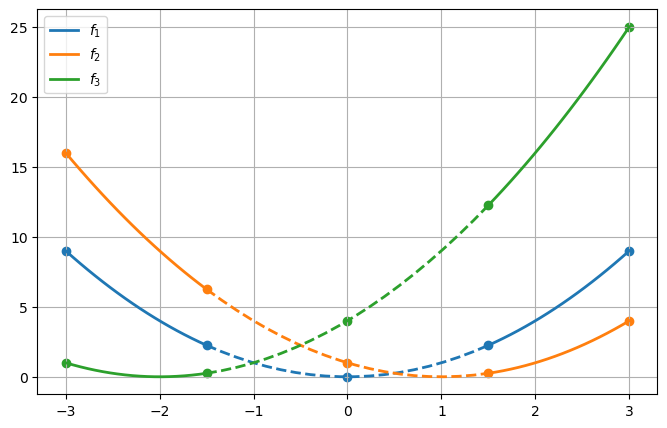

In [10]:
import matplotlib.pyplot as plt

def parabola(x, a):
    return (x - a) ** 2

l, m, r = [-3.0, -1.5], 0.0, [1.5, 3.0]
x_i = [np.linspace(l[0], l[1], 20), np.array([m]), np.linspace(r[0], r[1], 20), np.linspace(l[1], r[0], 20)]
f_1 = [parabola(x_, 0.0) for x_ in x_i]
f_2 = [parabola(x_, 1.0) for x_ in x_i]
f_3 = [parabola(x_, -2.0) for x_ in x_i]
f_s = [f_1[i] + f_2[i] + f_3[i] for i in range(4)]
x_min = [0.0, 1.5, -2.0]
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = [r'$f_1$', r'$f_2$', r'$f_3$']

plt.figure(figsize=(8, 5))

for f_v, lbl, c in zip([f_1, f_2, f_3], labels, colors):
    plt.plot(x_i[0], f_v[0], c=c, label=lbl, lw=2.0)
    plt.plot(x_i[2], f_v[2], c=c, lw=2.0)
    x_pt = [x_i[0][0], x_i[0][-1], x_i[1][0], x_i[2][0], x_i[2][-1]]
    f_pt = [f_v[0][0], f_v[0][-1], f_v[1][0], f_v[2][0], f_v[2][-1]]
    plt.scatter(x_pt, f_pt, c=c)
    plt.plot(x_i[3], f_v[3], linestyle='--', c=c, lw=2.0) 
plt.grid()
plt.legend()
plt.show()


Процесс формирования оптимизационной модели для задачи (3) концептуально похож на тот, что был для задач (1) и (2) - опишем его кодом ниже, снабдив необходимыми комментариями:

In [11]:
import pyomo.environ as pyo
from pyomo.gdp import Disjunction

# формирование объекта модели pyomo
model = pyo.ConcreteModel('gdp_sample')
# общий диапазон для всех переменных [-3.0, 3.0]
model.x = pyo.Var(range(0, 3), domain=pyo.Reals, bounds=(-3., 3.))

# задание целевой функции
a = [0.0, 1.0, -2.0]
obj_expr = sum((model.x[i] - a[i]) ** 2 for i in model.x)
model.obj = pyo.Objective(expr=obj_expr, sense=pyo.minimize)

# формирование правил для диапазонов поиска переменных с помощью функции Disjunction.
# в объекте Disjunction необходимо перечислить условия в виде ограничений
# всего у нас три переменных, поэтому задаем три группы условий, в каждой из которых будет выполняться только одно
model.djn = Disjunction(range(3))

# непосредственно задание условий для каждой из переменных
for i in range(3):
    model.djn[i] = [model.x[i] <= -1.5, model.x[i] == 0, model.x[i] >= 1.5]

'''
Перед началом решения необходимо произвести преобразование модели для дальнейшей передачи в солвер.
В данном случае преобразование произведем т.н. методом big-M, который позволяет
перекодировать логические условия в алгебраические,
сводя задачу к MINLP. Более подробно как устроен метод и пример формирования условий руками рассмотрим в следующей статье.
Здесь ниже оставим ссылку для ознакомления с подходом.
'''
pyo.TransformationFactory('gdp.bigm').apply_to(model)
solver = pyo.SolverFactory('bonmin')
res = solver.solve(model)
x_opt = [round(model.x[i].value, 3) for i in model.x]
print('Решение:', x_opt, ', f =', round(model.obj(), 2))


Решение: [-0.0, 1.5, -2.0] , f = 0.25


Как видим решение для $x$ совпадает с ожидаемым. А вот [Ссылка](https://en.wikipedia.org/wiki/Big_M_method) на метод big-M. 

### CVXPY

[__CVXPY__](https://www.cvxpy.org/index.html) - данный пакет был реализован для решения задач [выпуклой оптимизации](https://en.wikipedia.org/wiki/Convex_optimization).

Для решения задачи, по аналогии с __pyomo__, необходимо выполнить несколько шагов - определить переменные, задать целевую функцию и ограничения для формирования объекта оптимизационной задачи. После того как задача сформулирована, перед запуском солвера проверяется выпуклость целевой функции и ограничений с помощью правил [DCP](https://www.cvxpy.org/tutorial/dcp/index.html)
(disciplined convex programming). По сути это набор правил, которые однозначно гарантируют выпуклость функции, здесь стоит отметить, что эти правила - необходимые условия, но не достаточные, почему это так рассмотрим в примере ниже.
После проверки задача преобразуется для передачи солверу в формат, поддерживающий решение задач выпуклой оптимизации, в том числе cvxpy поддерживает коммерческие солверы -
полный список солверов можно посмотреть на этой [странице](https://www.cvxpy.org/tutorial/advanced/index.html), там же указаны все типы задач, которые позволяет решать __cvxpy__.
Также по аналогии с предыдущими пакетами рассмотрим применение __cvxpy__ на примерах.

Задачу (1) с помощью __cvxpy__ решить не удастся, так как целевая функция и ограничения в общем случае не являются выпуклыми и, соответственно, не подчиняются правилам DCP.
Целевая функция состоит из суммы слагаемых вида $f(x) = x e^{E(x-1)}$, вторая производная которой равна $f''(x) = E x e^{E(x-1)}(Ex + 2)$ и меняет свой знак в точке $x_{0} = \frac{-2}{E} = \frac{2}{|E|}$ (с учетом того, что $E \leqslant 0$) - то есть в общем случае не является выпуклой.

Рассмотрим другой пример: необходимо добраться из точки с координатами (0, 0) в точку (1, 2), область разделена на две части вдоль линии y = 1; до y = 1 максимальная скорость равна 1, а после в k (в примере k=1.5) раз меньше.
Очевидно, что самый быстрый путь - это движение по прямой линии с максимально скоростью на каждом из участков, при этом на границе не должно быть "разрывов" траектории.
В таком случае оптимизационную задачу можно сформулировать следующим образом:
\begin{cases}
\tag{4}
T = \sqrt{(x-x_{1})^2 + (y-y_{1})^2} + k \cdot \sqrt{(x-x_{2})^2 + (y-y_{2})^2} \to min,
\\
x_{1} = 0,\ y_{1} = 0,\ x_{2} = 1,\ y_{2} = 2,
\\
y = 1
\\
x \in [0; 2]
\end{cases}
Здесь в $T$ первое и второе слагаемые - это путь по прямой от начальной/конечной точки до точки на границе, деленный на скорость, другими словами время, затрачиваемое прохождение пути на 1-ом и 2-ом участках. Каждое из слагаемых является выпуклой функцией, а значит и их сумма тоже.

<img src="images/cvxpy_example.png" alt="drawing" width="1050"/>

In [12]:
import cvxpy as cp

X1, Y1 = 0.0, 0.0
X2, Y2 = 1.0, 2.0
K = 1.5

# задаем одну переменную x
X = cp.Variable(1)
Y_ = 1.0

# целевая функция - корни из суммы квадратов - являются выпуклыми
objective = cp.sqrt(cp.square(X - X1) + cp.square(Y_ - Y1) ** 2) +\
            cp.sqrt(cp.square(X2 - X) + cp.square(Y2 - Y_) ** 2)

# здесь единственное ограничение - это диапазон для x
constraints = []
constraints.extend([X >= 0.0, X <= X2])

# объявляем оптимизационную задачу, здесь берем минимизацию целевой функции
problem = cp.Problem(cp.Minimize(objective), constraints)

# совершаем проверку задачи на выпуклость согласно правилам DCP
print(f"is dcp: {problem.is_dcp()}")

is dcp: False


Как мы видим, исходно выпуклая задача не прошла проверку согласно правилам DCP, так как берется вогнутая функция от выпуклой,
но данная проблема решается просто вызовом функции norm для расчёта длины вектора (в нашем контексте расстояние), про которую __cvxpy__ известно, что она является выпуклой.
В модуле есть также еще дополнительный набор функций, которые не подчиняются DCP, но при этом выпуклые, например, log_sum_exp - логарифм от суммы экспонент.
Такие моменты необходимо учитывать при формулировке задач.

In [13]:
# скорректируем целевую функцию через вызов norm
objective = cp.norm(cp.hstack([X - X1, Y_ - Y1]), 2) + K * cp.norm(cp.hstack([X2 - X, Y2 - Y_]), 2)

# формируем ограничения и формируем задачу
constraints = []
constraints.extend([X >= 0.0, X <= X2])
problem = cp.Problem(cp.Minimize(objective), constraints)

# проверка на выпуклость
print(f"is dcp: {problem.is_dcp()}")

# решаем задачу путем вызова солвера ECOS
sol = problem.solve('ECOS')

# извлекаем решение
x_opt = X.value[0]
print(f"Решение: x = {round(x_opt, 3)}, f = {round(sol, 2)}")

is dcp: True
Решение: x = 0.623, f = 2.78


Также разберем как решается задача (2) с помощью __cvxpy__, так как пакет позволяет решать задачи LP(MILP).

In [14]:
# объявление переменных, отдельно целочисленных и непрерывных
x_i = cp.Variable(3, integer=True)
x_c = cp.Variable(1, nonneg=True)

# коэффициенты для целевой функции и ограничений
c = np.array([1., 2., 3., 1.])
A = np.array([3., 1., 2., 2.])
b = 7.0

# максимизация функции - сумма по целочисленной и непрерывной части переменных
obj = cp.Maximize(cp.sum(c[:3] @ x_i) + cp.sum(c[3:4] @ x_c))

# ограничения на диапазон и на общую сумму
cons = [
    x_i[0] <= 2, x_i[1] <= 1, x_i[2] <= 1,
    x_c <= 1,
    ((A[:3] @ x_i) + (A[3:4] @ x_c)) <= b
]

# формирование задачи и ее решение
prb = cp.Problem(obj, cons)
sol = prb.solve(verbose=False, solver='GLPK_MI')
x_opt = np.concatenate([x_i.value, x_c.value])

print(f"Решение: x = {list(np.round(x_opt, 2))}, f = {sol}, {prb.status}")

Решение: x = [1.0, 1.0, 1.0, 0.5], f = 6.5, optimal


## Заключение

В данной статье мы познакомились несколькими open-source библиотеками для решения оптимизационных задач.
Подводя итог, составим таблицу для рассмотренных в статье пакетов и какие типы задач они решают:


|  Пакеты в Python  |     Солвер(метод)    | NLP | LP | MILP | MINLP |
|-------------------|----------------------|-----|----|------|-------|
| scipy             | cobyla               | +   | -  | -    | -     |
| scipy             | slsqp                | +   | -  | -    | -     |
| scipy             | trust-constr         | +   | -  | -    | -     |
| scipy             | highs                | +   | +  | +    | -     |
| pyomo             | ipopt                | +   | +  | -    | -     |
| pyomo, cvxpy      | glpk                 | -   | +  | +    | -     |
| pyomo, cvxpy      | cbc                  | -   | +  | +    | -     |
| cvxpy             | ecos                 | +-  | +  | +    | -     |
| pyomo             | bonmin               | +   | +  | +    | +     |

Из рассмотренных примеров читатель может выбрать самый удобный для себя пакет/солвер, но остаётся вопрос,
какой из них будет быстрее работать? На этот вопрос мы планируем ответить в следующей статье.


Над статьёй работали: Будылин Михаил, Антон Денисов.